# Búsqueda Local: el primer  mejor vecino

Se  implementarásiguiendo  los  esquemas  de el  mejor,  y  de el primer  mejor vecino, según se explicó en el Tema 1 de teoría, usando el operador 2-opt.Se partirá de una solución inicial aleatoria.  
Los algoritmos de búsqueda local tienen su propia condición de parada, pero adicionalmente, en prevención de tiempos excesivos en algún caso, se añadirá una condición de parada alternativa (OR) basada en el número de evaluaciones que esté realizando la búsqueda, es decir, el número de vecesque se llame al cálculo de la función de coste.   
Este valor para la Búsqueda Local será de 1600·nllamadas a la función de coste.  
La búsqueda con cada algoritmo se debe ejecutar 10 veces consemillas distintas, como en el caso de la Aleatoria.

---
## Librerías
- matplotlib: necesaria para la representación de la solución.
- pandas: necesaria para la representación de resultados.
- random: necesaria para el control de números aleatorios.
- datetime: necesaria para la obtención de una semilla inicial que genere las demás semillas.
- multiprocessing: necesaria para la ejecución concurrente de las soluciones.
- itertools: necesaria para combinar las semillas con los dataset en la ejecución concurrente.
- ipynb: necesaria para cargar la función busqueda_aleatorio de otro fichero. Esto permite la ejecución concurrente en Jupyter.

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
from random import seed
from random import randint
from datetime import datetime
from multiprocessing import Pool, TimeoutError
import itertools
from ipynb.fs.full.algoritmo import *

---
## Funciones auxiliares

- cargar_fichero(nombre_fichero): devuelve un array con las ciudades almacenadas en el fichero. [ [ ciudad, posición x , posición y ] [...] ... ]
- calcular_distancia_euclidea(node_1,node_2): devuelve en la distancia entre las dos ciudades.
- dibujar_flecha(A, B): dibuja una flecha entre el punto A y B apuntando a B. 
- representacion(camino, nombre, distancia): representa las ciudades y el camino calculado.
- representacion_datos(result,nombre): representa la solución obtenida de la ejecución concurrente de un dataset.
- agregar_resultados(dataframe,nombre,result): guarda los resultados de la ejecución en el dataframe según la plantilla del pdf.

In [2]:
def cargar_fichero(nombre_fichero):
    
    fichero = open( "../Dataset/" + nombre_fichero + ".tsp", 'r')
    
    for i in range(3):
        fichero.readline()
        
    numero_de_ciudades = fichero.readline().strip().split()[1]
    
    for i in range(2):
        fichero.readline()
        
    ciudades = []
    for i in range(0, int(numero_de_ciudades)):
        ciudad,x,y = fichero.readline().strip().split()[:]
        ciudades.append([int(ciudad),float(x),float(y)])  
        
    fichero.close()
    
    return ciudades

In [3]:
def calcular_distancia_euclidea(ciudad_1,ciudad_2):
    
    x1,y1 = ciudad_1[1 :]
    x2,y2 = ciudad_2[1 :]
    
    xd = x1 - x2
    yd = y1 - y2
    
    return round(math.sqrt( xd*xd + yd*yd ))

In [4]:
def dibujar_flecha(A, B):
    plt.arrow(A[0], A[1], B[0] - A[0], B[1] - A[1],
              head_width=1.3, length_includes_head=True)

In [5]:
def representacion(camino, nombre, distancia):
    
    plt.figure(figsize=(10,10))
    
    for i in range(len(camino)):
        if(i == 0):
            plt.plot(camino[i][1], camino[i][2] , "o", color="green")
        else:
            plt.plot(camino[i][1], camino[i][2] , "*", color="red")
        
        if(i<len(camino)-1):
            dibujar_flecha([camino[i][1], camino[i][2]],[camino[i+1][1], camino[i+1][2]])
        else:
            dibujar_flecha([camino[i][1], camino[i][2]],[camino[0][1], camino[0][2]])
    
    plt.title(nombre + " : " + str(distancia))

In [6]:
def representacion_datos(result,nombre):
    semilla_coste = pd.DataFrame(columns=["Semilla","Coste","Nº de evaluaciones"])
    for i in range(10):
        semilla_coste.loc[len(semilla_coste)] = [semillas[i],result[i][1], result[i][2]]
    display(semilla_coste)

    print("Media coste: ", semilla_coste[['Coste']].mean()[0])
    print("Desviación típica coste: ", semilla_coste[['Coste']].std()[0])
    print("Media nº de evaluaciones: ", semilla_coste[['Nº de evaluaciones']].mean()[0])
    print("Desviación típica nº de evaluaciones: ", semilla_coste[['Nº de evaluaciones']].std()[0])


    print()
    print("Representación de la mejor solución: ")
    indice = semilla_coste[['Coste']].idxmin()[0]


    representacion(result[indice][0], nombre, result[indice][1])

In [7]:
def agregar_resultados(dataframe,nombre,result):

    for i in range(10):
        dataframe.loc["Ejecución "+str(i+1),(nombre,"Coste")] = result[i][1]

    dataframe.loc["Media",(nombre,"Coste")] = resultados.loc[:"Ejecución 10",(nombre,"Coste")].mean()
    dataframe.loc["Des. Tip. (s)",(nombre,"Coste")] = resultados.loc[:"Ejecución 10",(nombre,"Coste")].std()

    for i in range(10):
        dataframe.loc["Ejecución "+str(i+1),(nombre,"#Ev")] = result[i][2]

    dataframe.loc["Media",(nombre,"#Ev")] = resultados.loc[:"Ejecución 10",(nombre,"#Ev")].mean()
    dataframe.loc["Des. Tip. (s)",(nombre,"#Ev")] = resultados.loc[:"Ejecución 10",(nombre,"#Ev")].std()

---
## Función de evaluación
Esta función genera el coste total de la solución pasara por parámetro. Para ello recorre todas las ciudades de la solución sumando el coste entre ellas. 

In [8]:
def funcion_de_evaluacion(solucion):
    coste = 0
    for indice in range(len(solucion)-1):
        coste += calcular_distancia_euclidea(solucion[indice],solucion[indice+1])
    coste += calcular_distancia_euclidea(solucion[-1],solucion[0])
    return coste

---
## Lectura de ficheros y ejecución del algoritmo
Para poder ejecutar correctamente el algoritmo de forma concurrente en Jupyter, este debe ser cargado de forma externa. Para ello se ha usado la librería ipynb.

In [9]:
st70 = cargar_fichero("st70")
ch130 = cargar_fichero("ch130")
a280 = cargar_fichero("a280")
p654 = cargar_fichero("p654")
vm1084 = cargar_fichero("vm1084")
vm1748 = cargar_fichero("vm1748")

### Generación de semillas

In [10]:
semillas = []
dt = datetime.now()
for i in range(10):
    semillas.append(randint(0,dt.microsecond))
print("Semillas generadas:")
print(semillas)

Semillas generadas:
[134877, 240244, 85734, 166799, 119049, 382316, 118881, 323326, 347163, 126734]


## Dataframe para ver los resultados

In [11]:
mux = pd.MultiIndex.from_product([["St70","Ch130","A280","Pa654","Vm1084","Vm1748"], ['Coste','#Ev']])
resultados = pd.DataFrame(
    columns=mux,
    index = ['Ejecución 1', 'Ejecución 2', 'Ejecución 3',"Ejecución 4","Ejecución 5","Ejecución 6","Ejecución 7","Ejecución 8","Ejecución 9","Ejecución 10","Media","Des. Tip. (s)"]
)

#### st70

,Semilla,Coste,Nº de evaluaciones
0,134877.0,1198.0,66622.0
1,240244.0,1067.0,112000.0
2,85734.0,1034.0,89396.0
3,166799.0,1097.0,100103.0
4,119049.0,998.0,112000.0
5,382316.0,1039.0,80213.0
6,118881.0,1084.0,64762.0
7,323326.0,1083.0,112000.0
8,347163.0,1285.0,112000.0
9,126734.0,1018.0,104536.0


Media coste:  1090.3
Desviación típica coste:  88.02531201623518
Media nº de evaluaciones:  95363.2
Desviación típica nº de evaluaciones:  18977.66077260314

Representación de la mejor solución: 


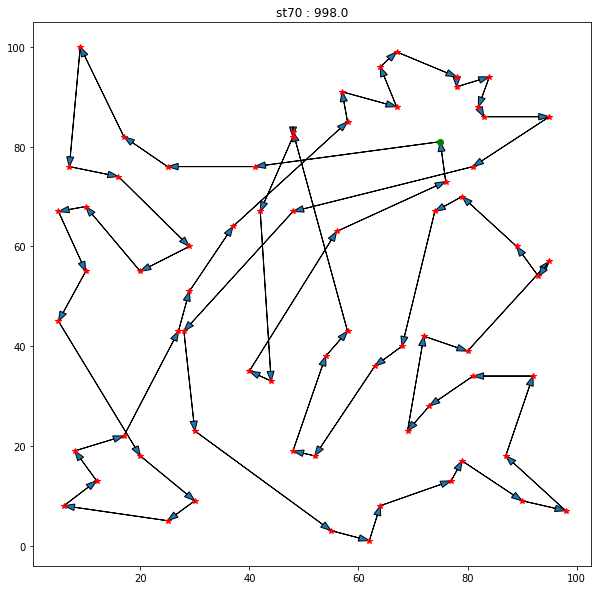

In [12]:
dataset = st70
with Pool(processes=5) as pool:
    result = pool.starmap(busqueda_local_el_primer_mejor_vecino,  itertools.product(semillas,[dataset]) )
representacion_datos(result,"st70")

agregar_resultados(resultados,"St70",result)

#### ch130


,Semilla,Coste,Nº de evaluaciones
0,134877.0,15764.0,208000.0
1,240244.0,15018.0,208000.0
2,85734.0,12473.0,208000.0
3,166799.0,15251.0,208000.0
4,119049.0,14735.0,208000.0
5,382316.0,12624.0,208000.0
6,118881.0,13635.0,208000.0
7,323326.0,13045.0,208000.0
8,347163.0,16471.0,208000.0
9,126734.0,13091.0,208000.0


Media coste:  14210.7
Desviación típica coste:  1414.6761741747748
Media nº de evaluaciones:  208000.0
Desviación típica nº de evaluaciones:  0.0

Representación de la mejor solución: 


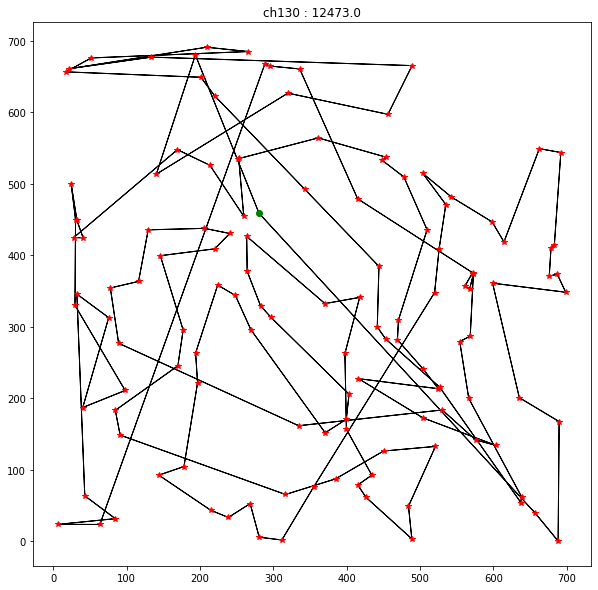

In [13]:
dataset = ch130

with Pool(processes=5) as pool:
    result = pool.starmap(busqueda_local_el_primer_mejor_vecino,  itertools.product(semillas,[dataset]) )
    
representacion_datos(result,"ch130")

agregar_resultados(resultados,"Ch130",result)

#### a280

,Semilla,Coste,Nº de evaluaciones
0,134877.0,10204.0,448000.0
1,240244.0,7901.0,448000.0
2,85734.0,8912.0,448000.0
3,166799.0,10038.0,448000.0
4,119049.0,9997.0,448000.0
5,382316.0,8449.0,448000.0
6,118881.0,13353.0,448000.0
7,323326.0,7517.0,448000.0
8,347163.0,10536.0,448000.0
9,126734.0,9643.0,448000.0


Media coste:  9655.0
Desviación típica coste:  1655.6505267316127
Media nº de evaluaciones:  448000.0
Desviación típica nº de evaluaciones:  0.0

Representación de la mejor solución: 


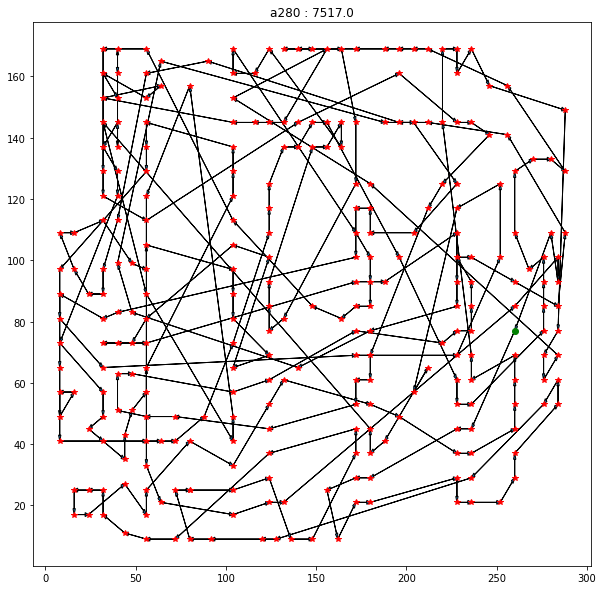

In [14]:
dataset = a280
with Pool(processes=5) as pool:
    result = pool.starmap(busqueda_local_el_primer_mejor_vecino,  itertools.product(semillas,[dataset]) )

representacion_datos(result,"a280")

agregar_resultados(resultados,"A280",result)

#### p654

,Semilla,Coste,Nº de evaluaciones
0,134877.0,525826.0,1046400.0
1,240244.0,664775.0,1046400.0
2,85734.0,432282.0,1046400.0
3,166799.0,567343.0,1046400.0
4,119049.0,487967.0,1046400.0
5,382316.0,678666.0,1046400.0
6,118881.0,496012.0,1046400.0
7,323326.0,465582.0,1046400.0
8,347163.0,544637.0,1046400.0
9,126734.0,675403.0,1046400.0


Media coste:  553849.3
Desviación típica coste:  90656.02183841218
Media nº de evaluaciones:  1046400.0
Desviación típica nº de evaluaciones:  0.0

Representación de la mejor solución: 


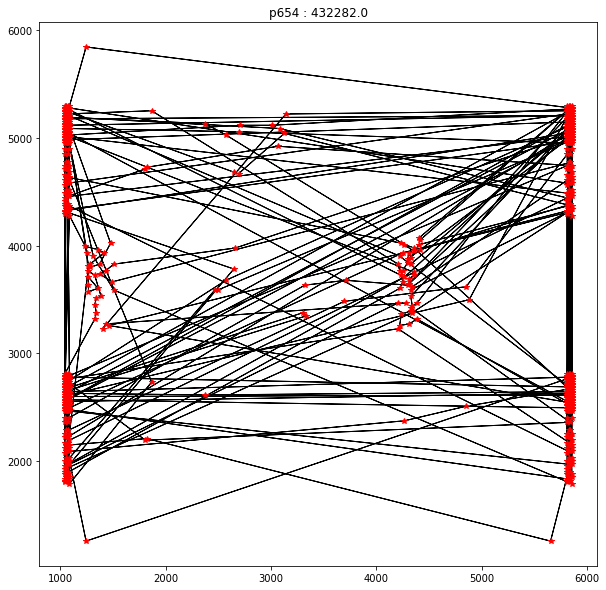

In [15]:
dataset = p654

with Pool(processes=5) as pool:
    result = pool.starmap(busqueda_local_el_primer_mejor_vecino,  itertools.product(semillas,[dataset]) )
    
representacion_datos(result,"p654")

agregar_resultados(resultados,"Pa654",result)

#### vm1084

,Semilla,Coste,Nº de evaluaciones
0,134877.0,3234770.0,1734400.0
1,240244.0,3355581.0,1734400.0
2,85734.0,4009915.0,1734400.0
3,166799.0,3705448.0,1734400.0
4,119049.0,3014575.0,1734400.0
5,382316.0,3856392.0,1734400.0
6,118881.0,3390939.0,1734400.0
7,323326.0,4928702.0,1734400.0
8,347163.0,3229159.0,1734400.0
9,126734.0,3215409.0,1734400.0


Media coste:  3594089.0
Desviación típica coste:  565192.3830339148
Media nº de evaluaciones:  1734400.0
Desviación típica nº de evaluaciones:  0.0

Representación de la mejor solución: 


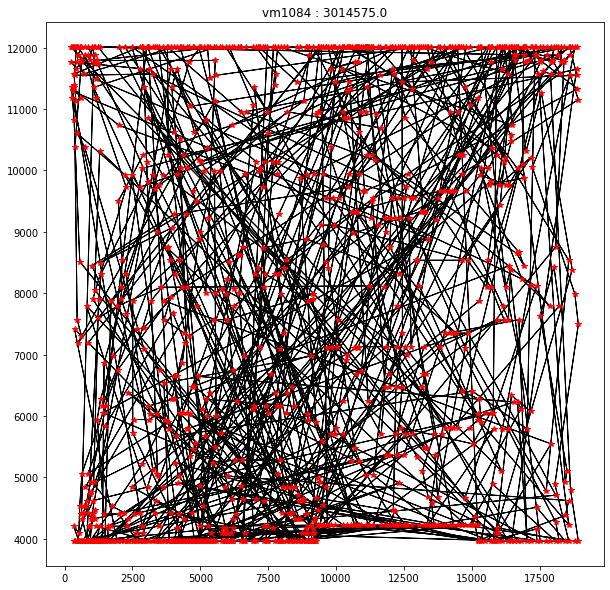

In [16]:
dataset = vm1084

with Pool(processes=5) as pool:
    result = pool.starmap(busqueda_local_el_primer_mejor_vecino,  itertools.product(semillas,[dataset]) )
    
representacion_datos(result,"vm1084")

agregar_resultados(resultados,"Vm1084",result)

#### vm1748

,Semilla,Coste,Nº de evaluaciones
0,134877.0,8200932.0,2796800.0
1,240244.0,7774568.0,2796800.0
2,85734.0,7481105.0,2796800.0
3,166799.0,7712646.0,2796800.0
4,119049.0,8416668.0,2796800.0
5,382316.0,7971610.0,2796800.0
6,118881.0,7742555.0,2796800.0
7,323326.0,7615341.0,2796800.0
8,347163.0,7850176.0,2796800.0
9,126734.0,7812913.0,2796800.0


Media coste:  7857851.4
Desviación típica coste:  276297.5083219777
Media nº de evaluaciones:  2796800.0
Desviación típica nº de evaluaciones:  0.0

Representación de la mejor solución: 


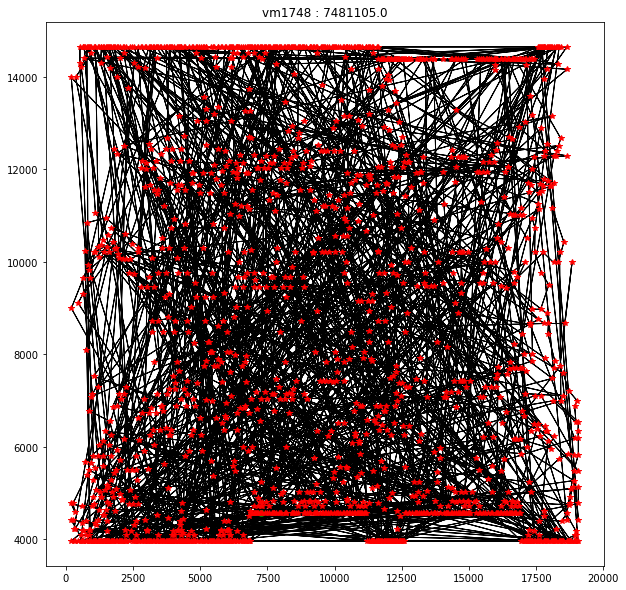

In [17]:
dataset = vm1748

with Pool(processes=5) as pool:
    result = pool.starmap(busqueda_local_el_primer_mejor_vecino,  itertools.product(semillas,[dataset]) )
    
representacion_datos(result,"vm1748")

agregar_resultados(resultados,"Vm1748",result)

---
# Resultados

In [18]:
resultados

St70                      Ch130                   A280  \
                   Coste           #Ev        Coste       #Ev        Coste   
Ejecución 1       1198.0         66622      15764.0    208000      10204.0   
Ejecución 2       1067.0        112000      15018.0    208000       7901.0   
Ejecución 3       1034.0         89396      12473.0    208000       8912.0   
Ejecución 4       1097.0        100103      15251.0    208000      10038.0   
Ejecución 5        998.0        112000      14735.0    208000       9997.0   
Ejecución 6       1039.0         80213      12624.0    208000       8449.0   
Ejecución 7       1084.0         64762      13635.0    208000      13353.0   
Ejecución 8       1083.0        112000      13045.0    208000       7517.0   
Ejecución 9       1285.0        112000      16471.0    208000      10536.0   
Ejecución 10      1018.0        104536      13091.0    208000       9643.0   
Media             1090.3       95363.2      14210.7  208000.0       9655.0   
Des. Tip. (s)  88.025312  18977.660773  1414.676174       0.0  1655.650527   

                                Pa654                    Vm1084             \
                    #Ev         Coste        #Ev          Coste        #Ev   
Ejecución 1      448000      525826.0    1046400      3234770.0    1734400   
Ejecución 2      448000      664775.0    1046400      3355581.0    1734400   
Ejecución 3      448000      432282.0    1046400      4009915.0    1734400   
Ejecución 4      448000      567343.0    1046400      3705448.0    1734400   
Ejecución 5      448000      487967.0    1046400      3014575.0    1734400   
Ejecución 6      448000      678666.0    1046400      3856392.0    1734400   
Ejecución 7      448000      496012.0    1046400      3390939.0    1734400   
Ejecución 8      448000      465582.0    1046400      4928702.0    1734400   
Ejecución 9      448000      544637.0    1046400      3229159.0    1734400   
Ejecución 10     448000      675403.0    1046400      3215409.0    1734400   
Media          448000.0      553849.3  1046400.0      3594089.0  1734400.0   
Des. Tip. (s)       0.0  90656.021838        0.0  565192.383034        0.0   

                      Vm1748             
                       Coste        #Ev  
Ejecución 1        8200932.0    2796800  
Ejecución 2        7774568.0    2796800  
Ejecución 3        7481105.0    2796800  
Ejecución 4        7712646.0    2796800  
Ejecución 5        8416668.0    2796800  
Ejecución 6        7971610.0    2796800  
Ejecución 7        7742555.0    2796800  
Ejecución 8        7615341.0    2796800  
Ejecución 9        7850176.0    2796800  
Ejecución 10       7812913.0    2796800  
Media              7857851.4  2796800.0  
Des. Tip. (s)  276297.508322        0.0

In [19]:
resultados.to_csv(r'./Resultados.csv')